In [1]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL 

from sklearn import model_selection, metrics, preprocessing
from sklearn.metrics import mean_squared_error
from umap import UMAP

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


### Get data from Neo4j

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
  with driver.session() as session:
    result = session.run(query)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [4]:
query = """
MATCH (u:User) -[r:RATED]-> (m:Movie)
RETURN u.userId AS userId, 
    m.movieId AS movieId, 
    r.rating AS rating
ORDER BY userId, movieId
"""

df = fetch_data(query)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [5]:
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [6]:
assert len(df) == 100004, 'Query result is wrong!'

In [7]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()

print(f'# Users: {n_users}\n# Movies: {n_movies}')

# Users: 671
# Movies: 9066


In [8]:
df['rating'].value_counts()

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

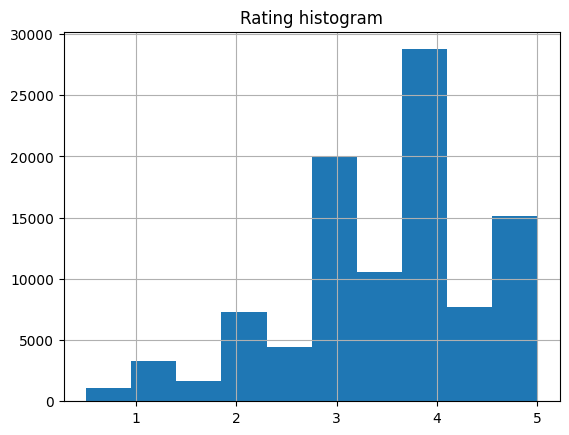

In [9]:
df['rating'].hist(bins=10)
plt.title('Rating histogram')
plt.show()

### Create PyTorch Dataset

In [10]:
class MovieDataset:
    def __init__(self, users:np.array, movies:np.array, ratings:np.array) -> None:
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self) -> int:
        return len(self.users)

    def __getitem__(self, item:int) -> dict:

        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users), #dtype=torch.long
            "movies": torch.tensor(movies), #dtype=torch.long
            "ratings": torch.tensor(ratings) #dtype=torch.long
        }

In [11]:
# Reset user ID's and movie ID's to starting index 0.
# This avoids index errors
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df['userId'] = lbl_user.fit_transform(df['userId'].values)
df['movieId'] = lbl_movie.fit_transform(df['movieId'].values)

In [12]:
df_train, df_val = model_selection.train_test_split(
    df, test_size=0.2, random_state=33, stratify=df['rating'].values)

df_test, df_val = model_selection.train_test_split(
    df_val, test_size=0.5, random_state=33, stratify=df_val['rating'].values)

In [13]:
train_dataset = MovieDataset(
    users=df_train['userId'].values,
    movies=df_train['movieId'].values,
    ratings=df_train['rating'].values)

val_dataset = MovieDataset(
    users=df_val['userId'].values,
    movies=df_val['movieId'].values,
    ratings=df_val['rating'].values)

test_dataset = MovieDataset(
    users=df_val['userId'].values,
    movies=df_val['movieId'].values,
    ratings=df_val['rating'].values)

print(f'Train: {len(train_dataset)}\nVal: {len(val_dataset)}\nTest: {len(test_dataset)}')

Train: 80003
Val: 10001
Test: 10001


In [14]:
train_dataset.__getitem__(0)

{'users': tensor(29),
 'movies': tensor(2965),
 'ratings': tensor(4., dtype=torch.float64)}

In [15]:
BATCH_SIZE = 256
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True)

### Define Model

In [17]:
class RecSysModel(nn.Module):
    def __init__(self, n_users:int, n_movies:int, embedding_dim:int) -> None:
        super().__init__()
        self.user_embed = nn.Embedding(num_embeddings=n_users, embedding_dim=embedding_dim)
        self.movie_embed = nn.Embedding(num_embeddings=n_movies, embedding_dim=embedding_dim)
        self.out = nn.Linear(in_features=embedding_dim*2, out_features=1)

    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        embeds_concat = torch.cat([user_embeds, movie_embeds], dim=1)
        output = self.out(embeds_concat)

        return output, user_embeds

In [18]:
EMBEDDING_DIM = 8

model = RecSysModel(
    n_users=n_users,
    n_movies=n_movies,
    embedding_dim=EMBEDDING_DIM
).to(device)

In [19]:
model.user_embed.weight.size(), model.user_embed.weight[0]

(torch.Size([671, 8]),
 tensor([ 0.7802,  0.0026,  2.5297, -0.1949,  0.7636, -0.7671, -1.9785, -1.5242],
        grad_fn=<SelectBackward0>))

### Train Model

In [21]:
EPOCHS = 20

optimizer = torch.optim.Adam(model.parameters())
# loss_func = nn.MSELoss()

print_prec = 5
n_batches = len(train_loader)
n_batches_val = len(val_loader)
size = len(train_loader.dataset)
size_val = len(val_loader.dataset)
loss_hist, mse_hist, loss_hist_val, mse_hist_val = [], [], [], []
user_embeddings, movie_embeddings = [model.user_embed], [model.movie_embed]
for epoch in range(EPOCHS):
    cost = 0.0
    for i, train_data in enumerate(train_loader):
        # Train
        model.train(True)
        output, _ = model(train_data['users'], train_data['movies'])
        rating = train_data['ratings'].view(BATCH_SIZE, -1).to(torch.float32)

        # loss = loss_func(output, rating)
        loss = F.mse_loss(output, rating).sqrt()
        cost += loss.sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    batch_loss = cost / n_batches
    avg_mse = cost / size
    # user_embeddings.append(model.user_embed), movie_embeddings.append(model.user_embed)

    with torch.no_grad(): #no gradients for test data
        val_cost = 0.0
        for i, val_data in enumerate(val_loader):
            output, _ = model(val_data['users'], val_data['movies'])
            rating = val_data['ratings'].view(BATCH_SIZE, -1).to(torch.float32)

            # val_loss = loss_func(output, rating)
            val_loss = F.mse_loss(output, rating).sqrt()
            val_cost += val_loss.sum().item()

            batch_loss_val = val_cost / n_batches_val
            avg_mse_val = val_cost / size_val
        # user_embeddings.append(model.user_embed), movie_embeddings.append(model.user_embed)

    loss_hist.append(batch_loss), loss_hist_val.append(batch_loss_val)
    # mse_hist.append(avg_mse), mse_hist_val.append(avg_mse_val)

    print(f'epoch: {epoch+1}\ttrain loss: {round(batch_loss, print_prec)}\tval loss: {round(batch_loss_val, print_prec)}')


epoch: 1	train loss: 3.28947	val loss: 2.78383
epoch: 2	train loss: 2.21747	val loss: 1.81514
epoch: 3	train loss: 1.54603	val loss: 1.38766
epoch: 4	train loss: 1.24526	val loss: 1.18695
epoch: 5	train loss: 1.10457	val loss: 1.08505
epoch: 6	train loss: 1.03115	val loss: 1.0275
epoch: 7	train loss: 0.9898	val loss: 0.99435
epoch: 8	train loss: 0.96231	val loss: 0.97141
epoch: 9	train loss: 0.94203	val loss: 0.95517
epoch: 10	train loss: 0.92607	val loss: 0.94314
epoch: 11	train loss: 0.91215	val loss: 0.93445
epoch: 12	train loss: 0.89992	val loss: 0.92619
epoch: 13	train loss: 0.88964	val loss: 0.92018
epoch: 14	train loss: 0.88052	val loss: 0.9151
epoch: 15	train loss: 0.87272	val loss: 0.91152
epoch: 16	train loss: 0.86571	val loss: 0.90945
epoch: 17	train loss: 0.85987	val loss: 0.9076
epoch: 18	train loss: 0.85476	val loss: 0.90529
epoch: 19	train loss: 0.84996	val loss: 0.90486
epoch: 20	train loss: 0.84596	val loss: 0.90373


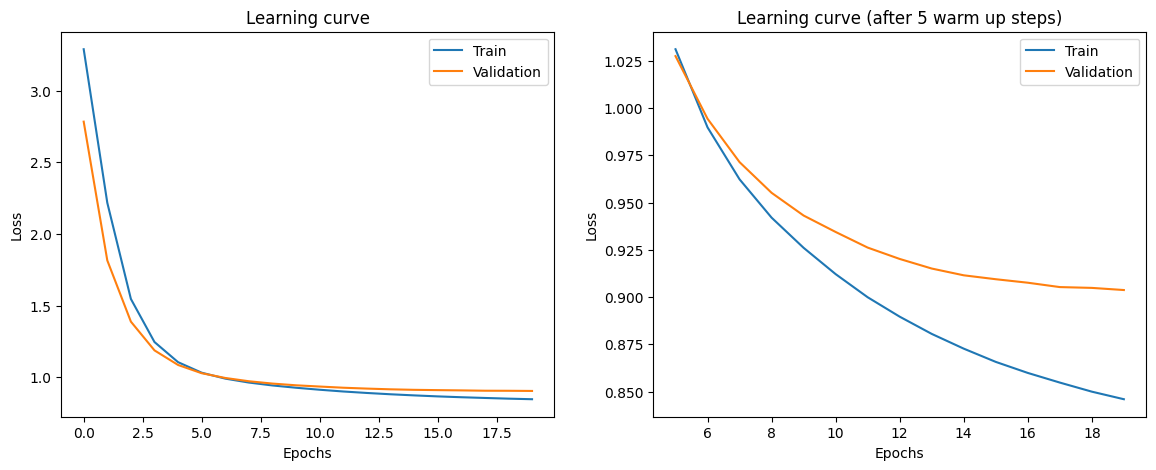

In [22]:
SKIP_WARM_UP_STEPS = 5

_, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax0.plot(loss_hist, label='Train')
ax0.plot(loss_hist_val, label='Validation')
ax0.set_title('Learning curve')
ax0.set_xlabel('Epochs')
ax0.set_ylabel('Loss')
ax0.legend()

ax1.plot(range(SKIP_WARM_UP_STEPS, len(loss_hist)), loss_hist[SKIP_WARM_UP_STEPS:], label='Train')
ax1.plot(range(SKIP_WARM_UP_STEPS, len(loss_hist_val)), loss_hist_val[SKIP_WARM_UP_STEPS:], label='Validation')
ax1.set_title(f'Learning curve (after {SKIP_WARM_UP_STEPS} warm up steps)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()

In [23]:
model.user_embed.weight.size(), model.user_embed.weight[0]

(torch.Size([671, 8]),
 tensor([ 1.3945,  0.5853,  1.9639, -0.7709,  1.3380, -1.3208, -1.3938, -0.9372],
        grad_fn=<SelectBackward0>))

In [24]:
user_embeddings = model.user_embed.weight.detach().numpy()
user_embeddings.shape

(671, 8)

In [25]:
# saving
safe_date = datetime.now().strftime('%Y%m%d')
base_path = f'./datasets/{safe_date}'

np.save(f'{base_path}_np_user_embeddings.npy', user_embeddings)

In [26]:
umap_2d = UMAP(n_neighbors=15, n_components=2, init='random', random_state=11)
plot_embed_umap_2d = umap_2d.fit_transform(user_embeddings)
plot_embed_umap_2d.shape

(671, 2)

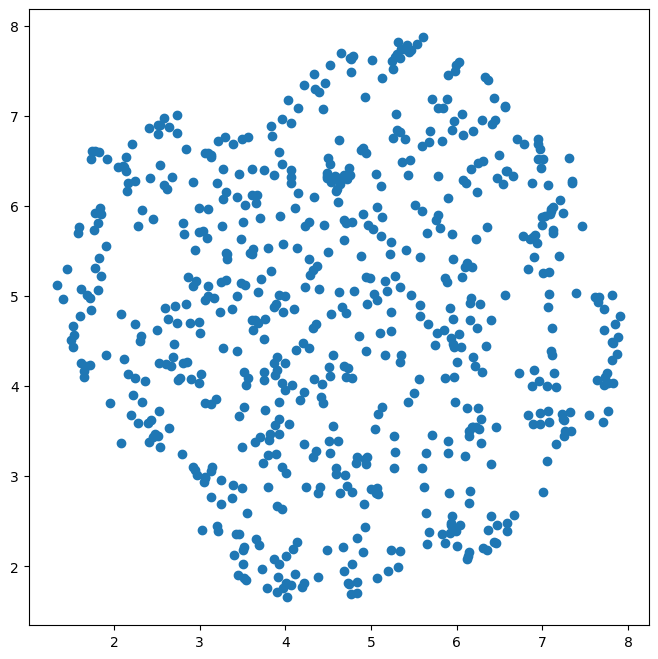

In [27]:
plt.figure(figsize=(8,8))
plt.scatter(x=plot_embed_umap_2d[:,0], y=plot_embed_umap_2d[:,1])
plt.show()

## Evaluation

In [28]:
user_est_true = defaultdict(list)

with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        users = test_data['users']
        movies = test_data['movies']
        ratings = test_data['ratings']

        model_output, _ = model(test_data['users'],
                             test_data['movies'])

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            #print(f'{user_id}, {movie_id}, {pred_rating}, {true_rating}')
            user_est_true[user_id].append((pred_rating, true_rating))

user_est_true

defaultdict(list,
            {462: [(3.589526653289795, 4.0),
              (2.896544933319092, 1.0),
              (3.6014766693115234, 4.0),
              (3.3562169075012207, 4.0),
              (3.3152260780334473, 4.0),
              (3.7576942443847656, 4.0),
              (2.749415636062622, 2.0),
              (3.6151347160339355, 2.0),
              (4.042419910430908, 5.0),
              (3.5051326751708984, 3.0),
              (3.713191032409668, 4.0),
              (3.882401466369629, 3.0),
              (2.8964791297912598, 3.0),
              (3.534609317779541, 4.0),
              (3.093451738357544, 3.0),
              (3.312211036682129, 4.0),
              (3.088747262954712, 2.0),
              (2.759751796722412, 1.0),
              (3.6338367462158203, 4.0),
              (3.409982204437256, 2.0),
              (3.4515838623046875, 3.0),
              (3.640249252319336, 3.0),
              (3.5032920837402344, 3.0),
              (3.8466897010803223, 4.0),
      

In [29]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k = 20
    threshold = 4.0

    for uid, user_ratings in user_est_true.items():
        #print(f'uid: {uid}')
        
        # sort by predicted ratings
        user_ratings.sort(key=lambda x: x[0], reverse=True) 
        #print(len(user_ratings), user_ratings)
        # 
        n_rel = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings])
        n_rec_k = sum([(true_rating >= threshold) for (_, true_rating) in user_ratings[:k]])
        #print(f'n_rel: {n_rel}, n_rec_k: {n_rec_k}')

        n_rel_and_rec_k = sum([((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k]])
        #print(n_rel_and_rec_k)
        
        #print(f'uid: {uid}, n_rel: {n_rel}, n_rec_k: {n_rec_k}, n_rel_and_rec_k: {n_rel_and_rec_k}')
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        #break

In [30]:
prec_at_k = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

print(f'precisions @ {k}: {round(prec_at_k, 4)}')
print(f'recall @ {k}: {round(recall_at_k, 4)}')

precisions @ 20: 0.3793
recall @ 20: 0.3482
